# Pathway enrichment by DC
* using pathway gene sets downloaded in 2024-11-26_Pathway-Download.jpynb

# Set up workspace:

In [1]:
#load packages I need
import os
import tools
import scanpy as sc
import pandas as pd
import dandelion as ddl
from tqdm import tqdm
import matplotlib.pyplot as plt
import scanpy.external as sce
from matplotlib.pyplot import rc_context
import seaborn as sns

In [2]:
#show current directory 
os.getcwd()
os.chdir('/scratch/user/s4436039/scdata/Python_Integration_Sep')
os.getcwd()

'/scratch/user/s4436039/scdata/Python_Integration_Sep'

Print software versions:

In [3]:
sc.logging.print_header()

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.14.0 pandas==2.2.2 scikit-learn==1.5.0 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.12


In [4]:
ddl.logging.print_header()

dandelion==0.3.8 pandas==2.2.2 numpy==1.26.4 matplotlib==3.9.2 networkx==3.3 scipy==1.14.0


In [5]:
# read in data
data = sc.read_h5ad('NRclean_clustered.h5ad')

In [6]:
data

AnnData object with n_obs × n_vars = 498023 × 1268
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'keep_or_remove', 'leiden', 'celltype', 'leiden_DC', 'leiden_DC_v2', 'exclude_annots', 'leiden_M', 'Technology', 'cancer_type_broad', 'clean-leiden_0.8', 'clean-subcluster', 'clean-subcluster-v2', 'YS_sig', 'HSC_sig', 'CD5nDC2_up_vDC3', 'DC3_up_vCD5nDC2', 'CD5pDC2_up_vDC3', 'DC3_up_vCD5pDC2', 'DC3_up_vMono', 'Mono_up_vDC3', 'DC1_sig', 'DC2_sig', 'DC3_sig', 'DC_Axl_sig', 'DC2_up_DC3', 'DC3_up_DC2', 'mregDC_sig', 'cDC1_mregDC', 'cDC2_mregDC', 'NR_annotati

### Import Hallmark gene sets
* will be imported as a dictionary where each key is a sheet name, and each value is a dataframe (gene set)

In [7]:
os.chdir('/scratch/user/s4436039/scdata/Pathway-sets')
H_sets = pd.read_excel("hallmark_sets.xlsx", sheet_name=None)
os.chdir('/scratch/user/s4436039/scdata/Python_Integration_Sep')

In [8]:
# Print the sheet names
print(H_sets.keys())

dict_keys(['Sheet1', 'Sheet2', 'Sheet3', 'Sheet4', 'Sheet5', 'Sheet6', 'Sheet7', 'Sheet8', 'Sheet9', 'Sheet10', 'Sheet11', 'Sheet12', 'Sheet13', 'Sheet14', 'Sheet15', 'Sheet16', 'Sheet17', 'Sheet18', 'Sheet19', 'Sheet20', 'Sheet21', 'Sheet22', 'Sheet23', 'Sheet24', 'Sheet25', 'Sheet26', 'Sheet27', 'Sheet28', 'Sheet29', 'Sheet30', 'Sheet31', 'Sheet32', 'Sheet33', 'Sheet34', 'Sheet35', 'Sheet36', 'Sheet37', 'Sheet38', 'Sheet39', 'Sheet40', 'Sheet41', 'Sheet42', 'Sheet43', 'Sheet44', 'Sheet45', 'Sheet46', 'Sheet47', 'Sheet48', 'Sheet49', 'Sheet50'])


In [9]:
# Change keys to be gene set name (the first value in the 'gs_name' column) instead of Sheet1 etc 
H_sets2 = {df["gs_name"].iloc[0]: df for _, df in H_sets.items()}
H_sets = H_sets2

# Result
print(H_sets.keys())

dict_keys(['HALLMARK_ADIPOGENESIS', 'HALLMARK_ALLOGRAFT_REJECTION', 'HALLMARK_ANDROGEN_RESPONSE', 'HALLMARK_ANGIOGENESIS', 'HALLMARK_APICAL_JUNCTION', 'HALLMARK_APICAL_SURFACE', 'HALLMARK_APOPTOSIS', 'HALLMARK_BILE_ACID_METABOLISM', 'HALLMARK_CHOLESTEROL_HOMEOSTASIS', 'HALLMARK_COAGULATION', 'HALLMARK_COMPLEMENT', 'HALLMARK_DNA_REPAIR', 'HALLMARK_E2F_TARGETS', 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'HALLMARK_ESTROGEN_RESPONSE_EARLY', 'HALLMARK_ESTROGEN_RESPONSE_LATE', 'HALLMARK_FATTY_ACID_METABOLISM', 'HALLMARK_G2M_CHECKPOINT', 'HALLMARK_GLYCOLYSIS', 'HALLMARK_HEDGEHOG_SIGNALING', 'HALLMARK_HEME_METABOLISM', 'HALLMARK_HYPOXIA', 'HALLMARK_IL2_STAT5_SIGNALING', 'HALLMARK_IL6_JAK_STAT3_SIGNALING', 'HALLMARK_INFLAMMATORY_RESPONSE', 'HALLMARK_INTERFERON_ALPHA_RESPONSE', 'HALLMARK_INTERFERON_GAMMA_RESPONSE', 'HALLMARK_KRAS_SIGNALING_DN', 'HALLMARK_KRAS_SIGNALING_UP', 'HALLMARK_MITOTIC_SPINDLE', 'HALLMARK_MTORC1_SIGNALING', 'HALLMARK_MYC_TARGETS_V1', 'HALLMARK_MYC_TARGETS_V2', 'HALLMAR

In [10]:
H_sets

{'HALLMARK_ADIPOGENESIS':     gs_cat  gs_subcat                gs_name gene_symbol  entrez_gene  \
 0        H        NaN  HALLMARK_ADIPOGENESIS       ABCA1           19   
 1        H        NaN  HALLMARK_ADIPOGENESIS       ABCB8        11194   
 2        H        NaN  HALLMARK_ADIPOGENESIS       ACAA2        10449   
 3        H        NaN  HALLMARK_ADIPOGENESIS       ACADL           33   
 4        H        NaN  HALLMARK_ADIPOGENESIS       ACADM           34   
 ..     ...        ...                    ...         ...          ...   
 205      H        NaN  HALLMARK_ADIPOGENESIS      UQCR11        10975   
 206      H        NaN  HALLMARK_ADIPOGENESIS      UQCRC1         7384   
 207      H        NaN  HALLMARK_ADIPOGENESIS       UQCRQ        27089   
 208      H        NaN  HALLMARK_ADIPOGENESIS       VEGFB         7423   
 209      H        NaN  HALLMARK_ADIPOGENESIS       YWHAG         7532   
 
         ensembl_gene human_gene_symbol  human_entrez_gene human_ensembl_gene  \
 0  

## Seperate data into each DC subset

In [17]:
data_P = data[data.obs["sample_type_major2"] == "primary tumour"]

data_DC1 = data_P[data_P.obs["NR_annotations_simple"] == "cDC1"]
data_DC2 = data_P[data_P.obs["NR_annotations_simple"] == "cDC2"]
data_mregDC = data_P[data_P.obs["NR_annotations_simple"] == "mregDC"]

## Score DC subsets by enrichment for each gene set (each dataframe in dictionary)

In [ ]:
# Iterate through each gene set in H_sets - DC1
for set_name, gene_set_df in H_sets.items():
    # Extract the gene set from the 'gene_symbol' column of the dataframe
    gene_set = gene_set_df['gene_symbol'].tolist()
    
    # Score the cells using the gene set
    sc.tl.score_genes(data_DC1, gene_list=gene_set, score_name=f"{set_name}_score")

# Iterate through each gene set in H_sets - DC2
for set_name, gene_set_df in H_sets.items():
    # Extract the gene set from the 'gene_symbol' column of the dataframe
    gene_set = gene_set_df['gene_symbol'].tolist()
    
    # Score the cells using the gene set
    sc.tl.score_genes(data_DC2, gene_list=gene_set, score_name=f"{set_name}_score")

# Iterate through each gene set in H_sets - mregDC
for set_name, gene_set_df in H_sets.items():
    # Extract the gene set from the 'gene_symbol' column of the dataframe
    gene_set = gene_set_df['gene_symbol'].tolist()
    
    # Score the cells using the gene set
    sc.tl.score_genes(data_mregDC, gene_list=gene_set, score_name=f"{set_name}_score")

       'GPAT4', 'LEP', 'MIGA2', 'MRAP', 'MTARC2', 'ORM1', 'SLC66A3', 'SQOR'],
      dtype='object')


       'RARS1', 'TGFB1', 'WARS1'],
      dtype='object')


/home/s4436039/miniforge3/envs/env/lib/python3.12/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


       'FLNC', 'FYB1', 'KRT31', 'MAP3K20', 'NECTIN1', 'NECTIN2', 'NECTIN3',
       'NECTIN4', 'NRAP', 'PALS1', 'PDZD3', 'PECAM1'],
      dtype='object')
       'GC', 'HAO1', 'HSD3B1', 'NR0B2', 'NR1H4', 'SERPINA6', 'SOAT2', 'TTR'],
      dtype='object')
       'F11', 'F13B', 'F2', 'F9', 'FGA', 'FGG', 'GDA', 'GP9', 'HMGCS2',
       'HNF4A', 'HRG', 'LEFTY2', 'MBL2', 'MEP1A', 'MMP8', 'PECAM1', 'PLG',
       'PROZ', 'RGN'],
      dtype='object')
       'RBSN'],
      dtype='object')
       'POSTN', 'PRSS2', 'SCG2', 'SGCG', 'TGFB1'],
      dtype='object')
       'RETREG1', 'SEMA3B', 'SOX3'],
      dtype='object')
       'PLAAT3', 'SEMA3B', 'SERPINA5', 'SOX3', 'TH'],
      dtype='object')
       'GAD2', 'GAPDHS', 'H2AZ1', 'HAO2', 'HMGCS2', 'KMT5A', 'MIX23', 'XIST'],
      dtype='object')
       'MAP3K20', 'NSD2', 'PTTG3P', 'TENT4A', 'TGFB1'],
      dtype='object')
       'PGLS', 'RARS1'],
      dtype='object')
       'H1-0', 'H4C3', 'HBBP1', 'HBQ1', 'HBZ', 'MARCHF2', 'MARCHF8', 'PGLS',
      

/home/s4436039/miniforge3/envs/env/lib/python3.12/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


       'FLNC', 'FYB1', 'KRT31', 'MAP3K20', 'NECTIN1', 'NECTIN2', 'NECTIN3',
       'NECTIN4', 'NRAP', 'PALS1', 'PDZD3', 'PECAM1'],
      dtype='object')
       'GC', 'HAO1', 'HSD3B1', 'NR0B2', 'NR1H4', 'SERPINA6', 'SOAT2', 'TTR'],
      dtype='object')
       'F11', 'F13B', 'F2', 'F9', 'FGA', 'FGG', 'GDA', 'GP9', 'HMGCS2',
       'HNF4A', 'HRG', 'LEFTY2', 'MBL2', 'MEP1A', 'MMP8', 'PECAM1', 'PLG',
       'PROZ', 'RGN'],
      dtype='object')
       'RBSN'],
      dtype='object')
       'POSTN', 'PRSS2', 'SCG2', 'SGCG', 'TGFB1'],
      dtype='object')
       'RETREG1', 'SEMA3B', 'SOX3'],
      dtype='object')
       'PLAAT3', 'SEMA3B', 'SERPINA5', 'SOX3', 'TH'],
      dtype='object')
       'GAD2', 'GAPDHS', 'H2AZ1', 'HAO2', 'HMGCS2', 'KMT5A', 'MIX23', 'XIST'],
      dtype='object')
       'MAP3K20', 'NSD2', 'PTTG3P', 'TENT4A', 'TGFB1'],
      dtype='object')
       'PGLS', 'RARS1'],
      dtype='object')
       'H1-0', 'H4C3', 'HBBP1', 'HBQ1', 'HBZ', 'MARCHF2', 'MARCHF8', 'PGLS',
      

/home/s4436039/miniforge3/envs/env/lib/python3.12/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


       'FLNC', 'FYB1', 'KRT31', 'MAP3K20', 'NECTIN1', 'NECTIN2', 'NECTIN3',
       'NECTIN4', 'NRAP', 'PALS1', 'PDZD3', 'PECAM1'],
      dtype='object')
       'GC', 'HAO1', 'HSD3B1', 'NR0B2', 'NR1H4', 'SERPINA6', 'SOAT2', 'TTR'],
      dtype='object')
       'F11', 'F13B', 'F2', 'F9', 'FGA', 'FGG', 'GDA', 'GP9', 'HMGCS2',
       'HNF4A', 'HRG', 'LEFTY2', 'MBL2', 'MEP1A', 'MMP8', 'PECAM1', 'PLG',
       'PROZ', 'RGN'],
      dtype='object')
       'RBSN'],
      dtype='object')
       'POSTN', 'PRSS2', 'SCG2', 'SGCG', 'TGFB1'],
      dtype='object')
       'RETREG1', 'SEMA3B', 'SOX3'],
      dtype='object')
       'PLAAT3', 'SEMA3B', 'SERPINA5', 'SOX3', 'TH'],
      dtype='object')
       'GAD2', 'GAPDHS', 'H2AZ1', 'HAO2', 'HMGCS2', 'KMT5A', 'MIX23', 'XIST'],
      dtype='object')
       'MAP3K20', 'NSD2', 'PTTG3P', 'TENT4A', 'TGFB1'],
      dtype='object')
       'PGLS', 'RARS1'],
      dtype='object')
       'H1-0', 'H4C3', 'HBBP1', 'HBQ1', 'HBZ', 'MARCHF2', 'MARCHF8', 'PGLS',
      

## generate a heatmap of results:

/scratch/temp/11687049/ipykernel_1845247/734714644.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


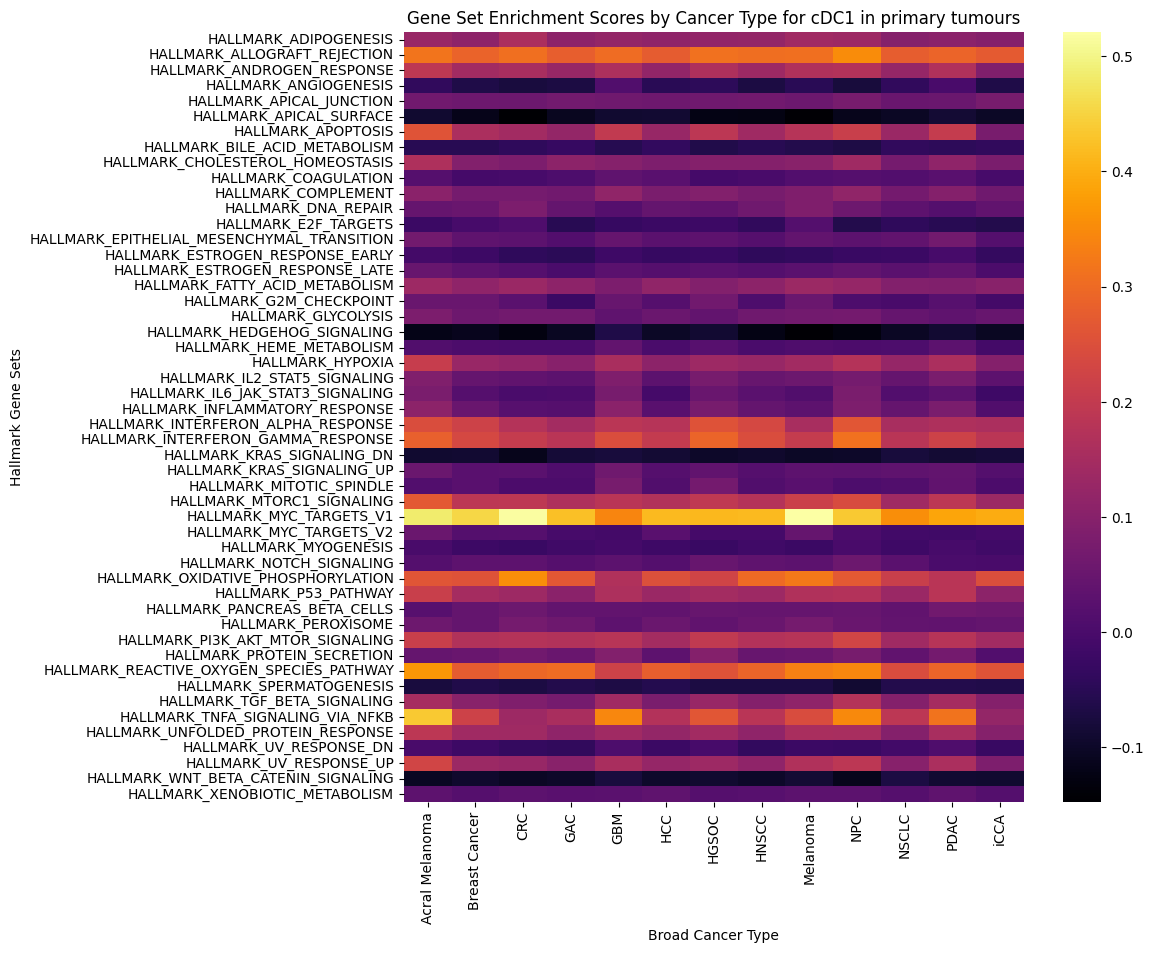

/scratch/temp/11687049/ipykernel_1845247/734714644.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


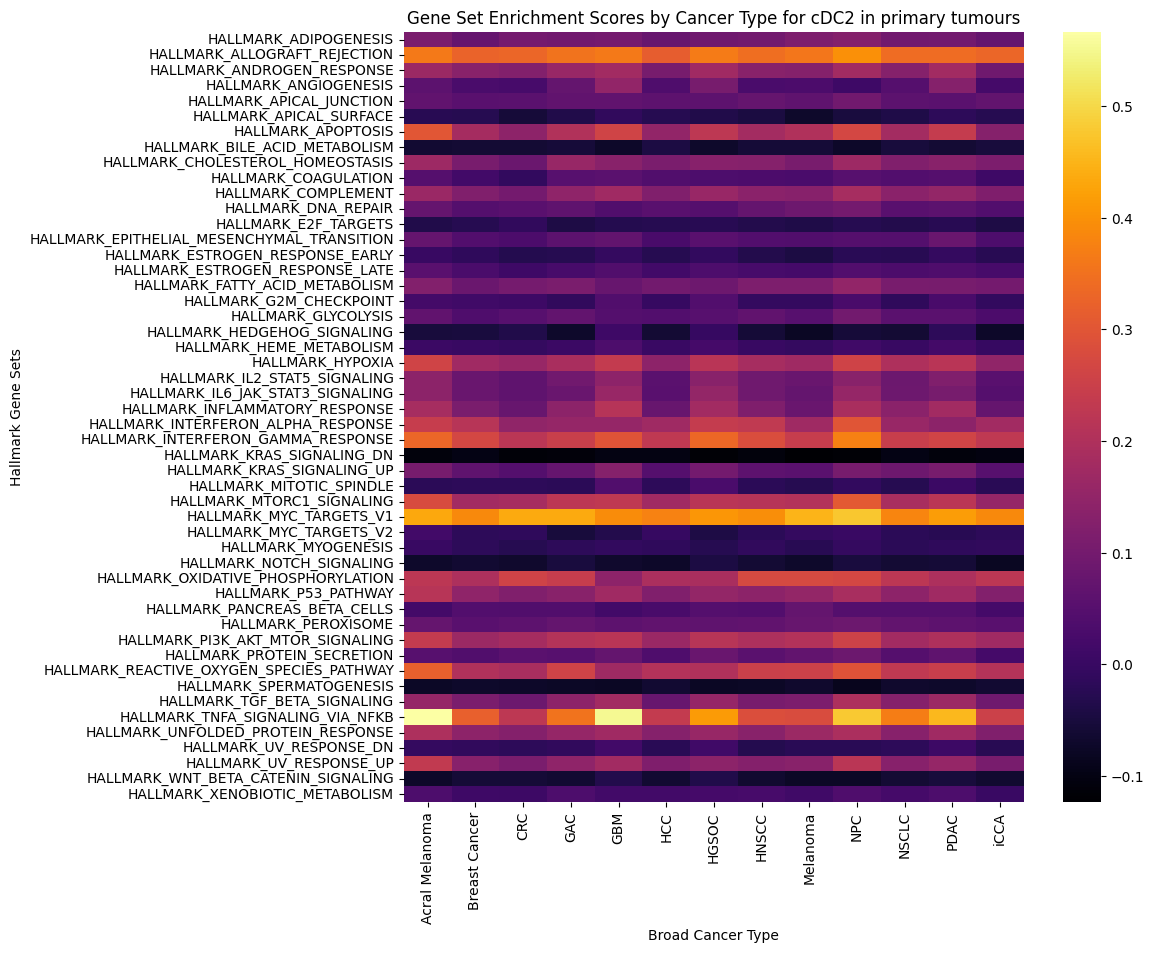

/scratch/temp/11687049/ipykernel_1845247/734714644.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


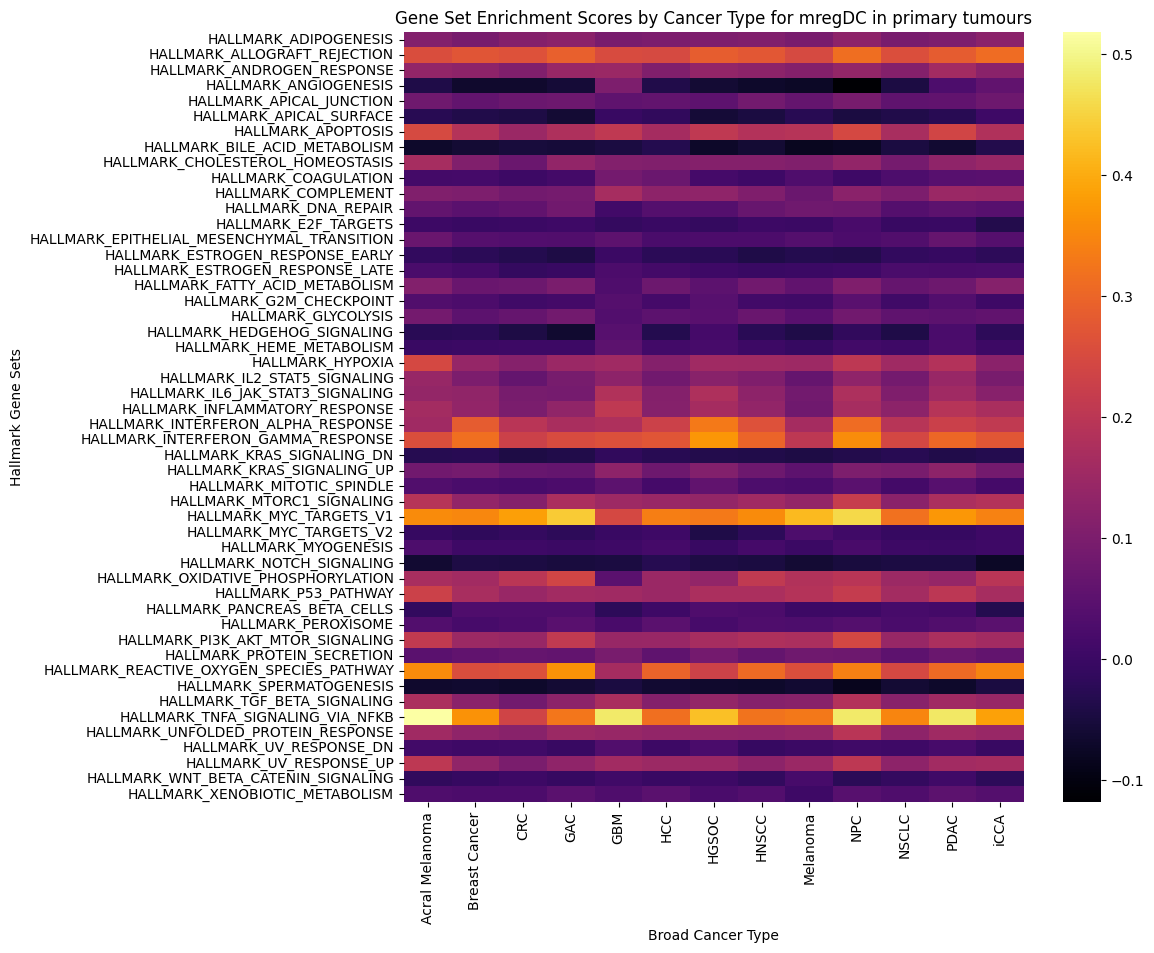

In [19]:
#DC1: 
# Extract gene set scores from `data_DC1.obs`
gene_set_scores = pd.DataFrame({
    set_name: data_DC1.obs[f"{set_name}_score"]
    for set_name in H_sets.keys()
})

# Add the cancer_type_broad metadata as a column
gene_set_scores["cancer_type_broad"] = data_DC1.obs["cancer_type_broad"].values

# Group by cancer_type_broad and compute mean scores for each group
grouped_scores = gene_set_scores.groupby("cancer_type_broad").mean().T

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(grouped_scores, cmap="inferno", yticklabels=True, xticklabels=True)
plt.xlabel("Broad Cancer Type")
plt.ylabel("Hallmark Gene Sets")
plt.title("Gene Set Enrichment Scores by Cancer Type for cDC1 in primary tumours")
plt.show()

#DC2:
# Extract gene set scores from `data_DC2.obs`
gene_set_scores = pd.DataFrame({
    set_name: data_DC2.obs[f"{set_name}_score"]
    for set_name in H_sets.keys()
})

# Add the cancer_type_broad metadata as a column
gene_set_scores["cancer_type_broad"] = data_DC2.obs["cancer_type_broad"].values

# Group by cancer_type_broad and compute mean scores for each group
grouped_scores = gene_set_scores.groupby("cancer_type_broad").mean().T

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(grouped_scores, cmap="inferno", yticklabels=True, xticklabels=True)
plt.xlabel("Broad Cancer Type")
plt.ylabel("Hallmark Gene Sets")
plt.title("Gene Set Enrichment Scores by Cancer Type for cDC2 in primary tumours")
plt.show()

#mregDC:
# Extract gene set scores from `data_DC1.obs`
gene_set_scores = pd.DataFrame({
    set_name: data_mregDC.obs[f"{set_name}_score"]
    for set_name in H_sets.keys()
})

# Add the cancer_type_broad metadata as a column
gene_set_scores["cancer_type_broad"] = data_mregDC.obs["cancer_type_broad"].values

# Group by cancer_type_broad and compute mean scores for each group
grouped_scores = gene_set_scores.groupby("cancer_type_broad").mean().T

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(grouped_scores, cmap="inferno", yticklabels=True, xticklabels=True)
plt.xlabel("Broad Cancer Type")
plt.ylabel("Hallmark Gene Sets")
plt.title("Gene Set Enrichment Scores by Cancer Type for mregDC in primary tumours")
plt.show()

### repeat for just OC to compare tissues:

In [21]:
data_OC = data[data.obs["cancer_with_H"] == "HGSOC"]

oc_DC1 = data_OC[data_OC.obs["NR_annotations_simple"] == "cDC1"]
oc_DC2 = data_OC[data_OC.obs["NR_annotations_simple"] == "cDC2"]
oc_mregDC = data_OC[data_OC.obs["NR_annotations_simple"] == "mregDC"]

## Score DC subsets by enrichment for each gene set (each dataframe in dictionary)

In [22]:
# Iterate through each gene set in H_sets - DC1
for set_name, gene_set_df in H_sets.items():
    # Extract the gene set from the 'gene_symbol' column of the dataframe
    gene_set = gene_set_df['gene_symbol'].tolist()
    
    # Score the cells using the gene set
    sc.tl.score_genes(oc_DC1, gene_list=gene_set, score_name=f"{set_name}_score")

# Iterate through each gene set in H_sets - DC2
for set_name, gene_set_df in H_sets.items():
    # Extract the gene set from the 'gene_symbol' column of the dataframe
    gene_set = gene_set_df['gene_symbol'].tolist()
    
    # Score the cells using the gene set
    sc.tl.score_genes(oc_DC2, gene_list=gene_set, score_name=f"{set_name}_score")

# Iterate through each gene set in H_sets - mregDC
for set_name, gene_set_df in H_sets.items():
    # Extract the gene set from the 'gene_symbol' column of the dataframe
    gene_set = gene_set_df['gene_symbol'].tolist()
    
    # Score the cells using the gene set
    sc.tl.score_genes(oc_mregDC, gene_list=gene_set, score_name=f"{set_name}_score")

       'GPAT4', 'LEP', 'MIGA2', 'MRAP', 'MTARC2', 'ORM1', 'SLC66A3', 'SQOR'],
      dtype='object')


       'RARS1', 'TGFB1', 'WARS1'],
      dtype='object')


/home/s4436039/miniforge3/envs/env/lib/python3.12/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


       'FLNC', 'FYB1', 'KRT31', 'MAP3K20', 'NECTIN1', 'NECTIN2', 'NECTIN3',
       'NECTIN4', 'NRAP', 'PALS1', 'PDZD3', 'PECAM1'],
      dtype='object')
       'GC', 'HAO1', 'HSD3B1', 'NR0B2', 'NR1H4', 'SERPINA6', 'SOAT2', 'TTR'],
      dtype='object')
       'F11', 'F13B', 'F2', 'F9', 'FGA', 'FGG', 'GDA', 'GP9', 'HMGCS2',
       'HNF4A', 'HRG', 'LEFTY2', 'MBL2', 'MEP1A', 'MMP8', 'PECAM1', 'PLG',
       'PROZ', 'RGN'],
      dtype='object')
       'RBSN'],
      dtype='object')
       'POSTN', 'PRSS2', 'SCG2', 'SGCG', 'TGFB1'],
      dtype='object')
       'RETREG1', 'SEMA3B', 'SOX3'],
      dtype='object')
       'PLAAT3', 'SEMA3B', 'SERPINA5', 'SOX3', 'TH'],
      dtype='object')
       'GAD2', 'GAPDHS', 'H2AZ1', 'HAO2', 'HMGCS2', 'KMT5A', 'MIX23', 'XIST'],
      dtype='object')
       'MAP3K20', 'NSD2', 'PTTG3P', 'TENT4A', 'TGFB1'],
      dtype='object')
       'PGLS', 'RARS1'],
      dtype='object')
       'H1-0', 'H4C3', 'HBBP1', 'HBQ1', 'HBZ', 'MARCHF2', 'MARCHF8', 'PGLS',
      

/home/s4436039/miniforge3/envs/env/lib/python3.12/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


       'FLNC', 'FYB1', 'KRT31', 'MAP3K20', 'NECTIN1', 'NECTIN2', 'NECTIN3',
       'NECTIN4', 'NRAP', 'PALS1', 'PDZD3', 'PECAM1'],
      dtype='object')
       'GC', 'HAO1', 'HSD3B1', 'NR0B2', 'NR1H4', 'SERPINA6', 'SOAT2', 'TTR'],
      dtype='object')
       'F11', 'F13B', 'F2', 'F9', 'FGA', 'FGG', 'GDA', 'GP9', 'HMGCS2',
       'HNF4A', 'HRG', 'LEFTY2', 'MBL2', 'MEP1A', 'MMP8', 'PECAM1', 'PLG',
       'PROZ', 'RGN'],
      dtype='object')
       'RBSN'],
      dtype='object')
       'POSTN', 'PRSS2', 'SCG2', 'SGCG', 'TGFB1'],
      dtype='object')
       'RETREG1', 'SEMA3B', 'SOX3'],
      dtype='object')
       'PLAAT3', 'SEMA3B', 'SERPINA5', 'SOX3', 'TH'],
      dtype='object')
       'GAD2', 'GAPDHS', 'H2AZ1', 'HAO2', 'HMGCS2', 'KMT5A', 'MIX23', 'XIST'],
      dtype='object')
       'MAP3K20', 'NSD2', 'PTTG3P', 'TENT4A', 'TGFB1'],
      dtype='object')
       'PGLS', 'RARS1'],
      dtype='object')
       'H1-0', 'H4C3', 'HBBP1', 'HBQ1', 'HBZ', 'MARCHF2', 'MARCHF8', 'PGLS',
      

/home/s4436039/miniforge3/envs/env/lib/python3.12/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


       'GC', 'HAO1', 'HSD3B1', 'NR0B2', 'NR1H4', 'SERPINA6', 'SOAT2', 'TTR'],
      dtype='object')
       'F11', 'F13B', 'F2', 'F9', 'FGA', 'FGG', 'GDA', 'GP9', 'HMGCS2',
       'HNF4A', 'HRG', 'LEFTY2', 'MBL2', 'MEP1A', 'MMP8', 'PECAM1', 'PLG',
       'PROZ', 'RGN'],
      dtype='object')
       'RBSN'],
      dtype='object')
       'POSTN', 'PRSS2', 'SCG2', 'SGCG', 'TGFB1'],
      dtype='object')
       'RETREG1', 'SEMA3B', 'SOX3'],
      dtype='object')
       'PLAAT3', 'SEMA3B', 'SERPINA5', 'SOX3', 'TH'],
      dtype='object')
       'GAD2', 'GAPDHS', 'H2AZ1', 'HAO2', 'HMGCS2', 'KMT5A', 'MIX23', 'XIST'],
      dtype='object')
       'MAP3K20', 'NSD2', 'PTTG3P', 'TENT4A', 'TGFB1'],
      dtype='object')
       'PGLS', 'RARS1'],
      dtype='object')
       'H1-0', 'H4C3', 'HBBP1', 'HBQ1', 'HBZ', 'MARCHF2', 'MARCHF8', 'PGLS',
       'RHAG', 'SLC30A10', 'SLC4A1', 'SLC66A2', 'SPTA1', 'TENT5C', 'TRIM10',
       'TSPO2', 'TYR'],
      dtype='object')
       'GAPDHS', 'IGFBP1', 'INHA', '

## generate a heatmap of results:

/scratch/temp/11687049/ipykernel_1845247/583581363.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


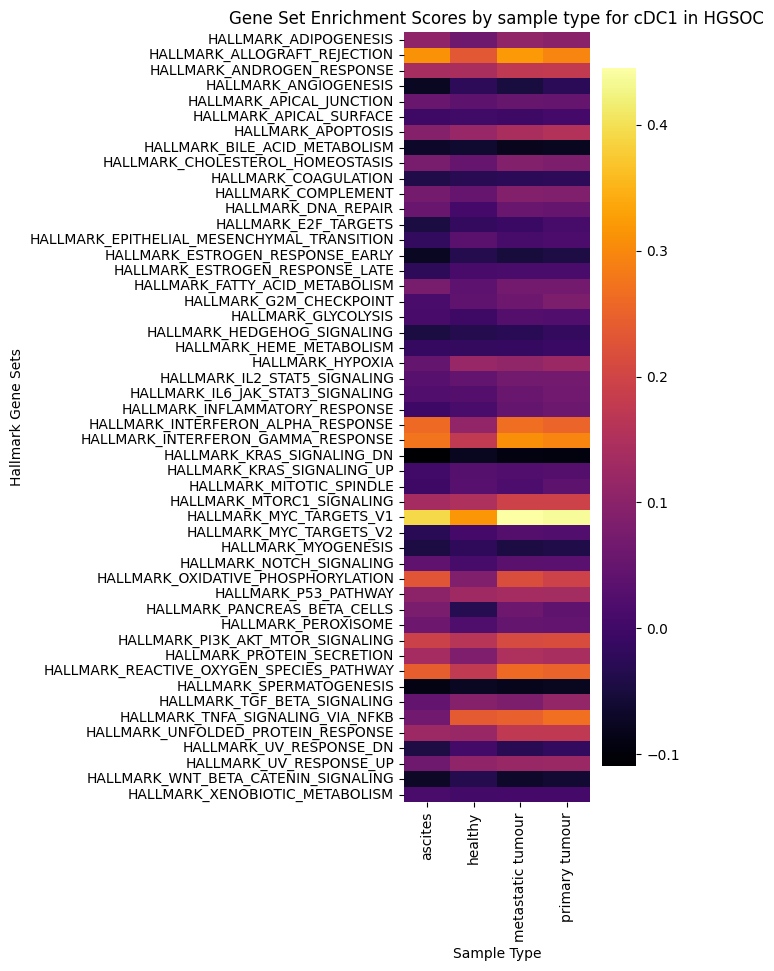

/scratch/temp/11687049/ipykernel_1845247/583581363.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


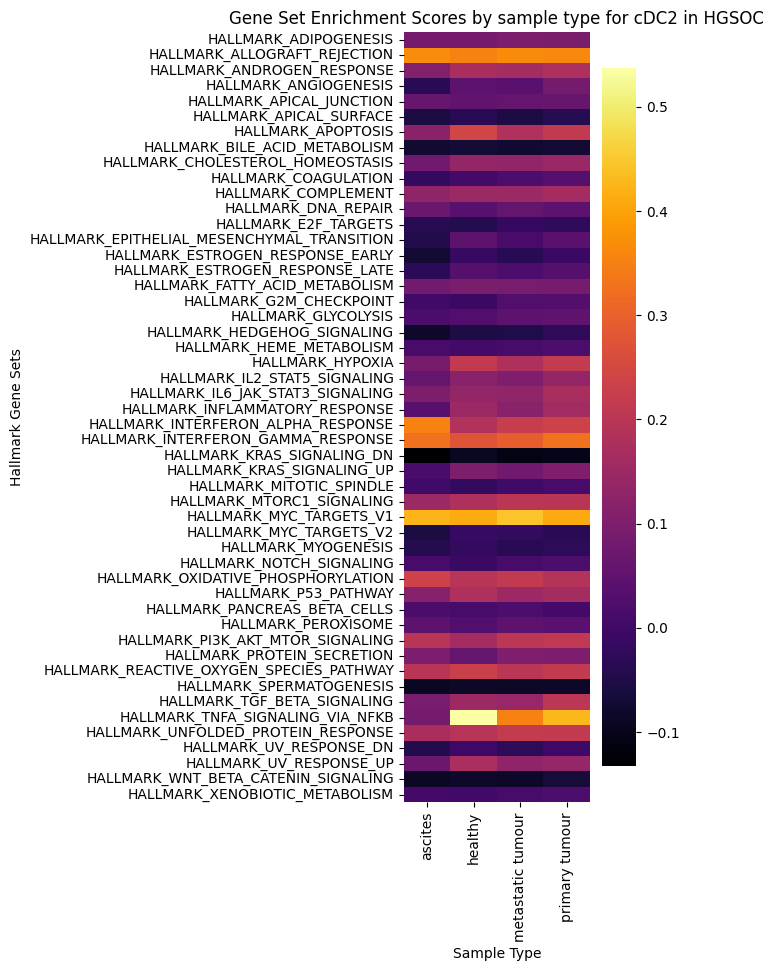

/scratch/temp/11687049/ipykernel_1845247/583581363.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


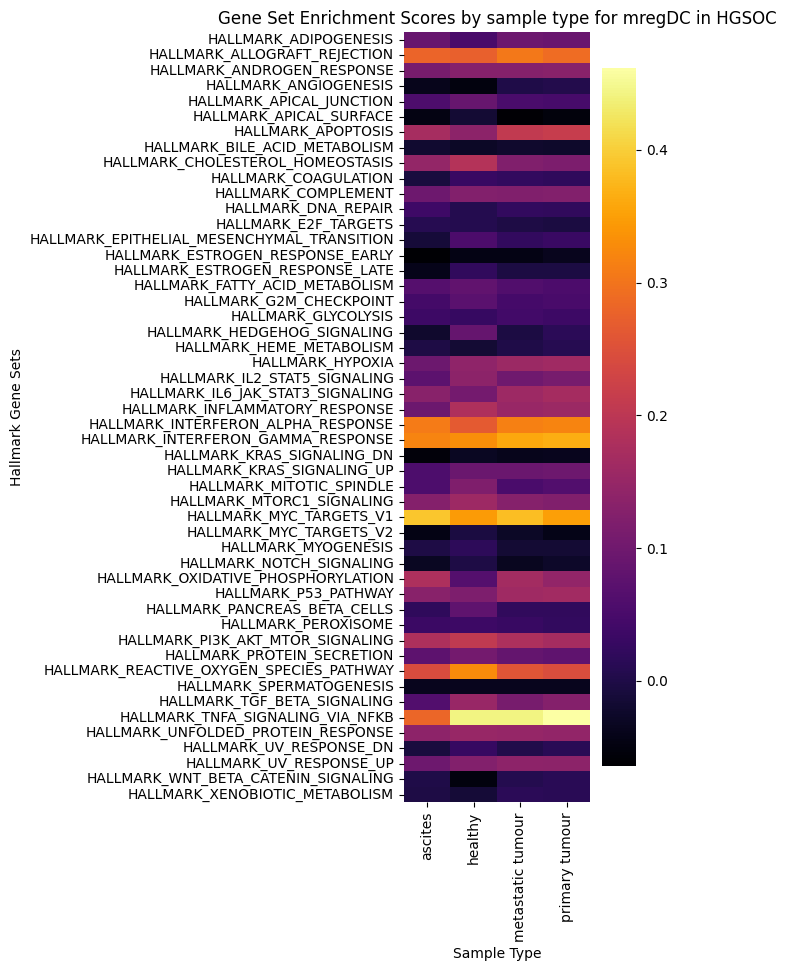

In [27]:
#DC1: 
# Extract gene set scores from `oc_DC1.obs`
gene_set_scores = pd.DataFrame({
    set_name: oc_DC1.obs[f"{set_name}_score"]
    for set_name in H_sets.keys()
})

# Add the sample_type_major2 metadata as a column
gene_set_scores["sample_type_major2"] = oc_DC1.obs["sample_type_major2"].values

# Group by sample_type_major2 and compute mean scores for each group
grouped_scores = gene_set_scores.groupby("sample_type_major2").mean().T

# Plot the heatmap
plt.figure(figsize=(3, 10))
sns.heatmap(grouped_scores, cmap="inferno", yticklabels=True, xticklabels=True)
plt.xlabel("Sample Type")
plt.ylabel("Hallmark Gene Sets")
plt.title("Gene Set Enrichment Scores by sample type for cDC1 in HGSOC")
plt.show()

#DC2:
# Extract gene set scores from `oc_DC2.obs`
gene_set_scores = pd.DataFrame({
    set_name: oc_DC2.obs[f"{set_name}_score"]
    for set_name in H_sets.keys()
})

# Add the sample_type_major2 metadata as a column
gene_set_scores["sample_type_major2"] = oc_DC2.obs["sample_type_major2"].values

# Group by sample_type_major2 and compute mean scores for each group
grouped_scores = gene_set_scores.groupby("sample_type_major2").mean().T

# Plot the heatmap
plt.figure(figsize=(3, 10))
sns.heatmap(grouped_scores, cmap="inferno", yticklabels=True, xticklabels=True)
plt.xlabel("Sample Type")
plt.ylabel("Hallmark Gene Sets")
plt.title("Gene Set Enrichment Scores by sample type for cDC2 in HGSOC")
plt.show()

#mregDC:
# Extract gene set scores from `oc_mregDC.obs`
gene_set_scores = pd.DataFrame({
    set_name: oc_mregDC.obs[f"{set_name}_score"]
    for set_name in H_sets.keys()
})

# Add the sample_type_major2 metadata as a column
gene_set_scores["sample_type_major2"] = oc_mregDC.obs["sample_type_major2"].values

# Group by sample_type_major2 and compute mean scores for each group
grouped_scores = gene_set_scores.groupby("sample_type_major2").mean().T

# Plot the heatmap
plt.figure(figsize=(3, 10))
sns.heatmap(grouped_scores, cmap="inferno", yticklabels=True, xticklabels=True)
plt.xlabel("Sample Type")
plt.ylabel("Hallmark Gene Sets")
plt.title("Gene Set Enrichment Scores by sample type for mregDC in HGSOC")
plt.show()

## old:

### Overlay my tumour uptake signature: 

In [ ]:
#make an object with my sig - see excel file Nikita-mregDC_DEG_summary on i drive
Uptake_sig = ["CCL22","IL4I1","SIRPA","CCR7","CHST11","GPR157","RGS1","BIRC3","TRAF1","CSF2RA","TBC1D13","LAMP3","MREG","PPP1R14A","SPRED2","CD83","TXN","MOB3A","NFKB1","TBC1D4","CDK2","WFDC21P","ARAP2","ZER1","ACSL1","SPINT2","SQSTM1","TBC1D8","JAG1","AC073508.3","BATF","ETV3","BCL2","KIF2A","FSCN1","TNFAIP3","CCDC28B","NR4A3","CYTIP","PLEK","FOXO1","TOMM34","TRAFD1","PPP1R16B","CXCR4","CD40","ENTPD7","CDKN1A","BID","MARCKS","DUSP5","MAP4K4","BCL2L1","ISG20","RNF145","RNF121","GPR132","RASGEF1B","CYRIA","RAB10","CERS6","IL1R1","STK4","CLEC2D","AL390719.1","ZBTB38","IFNGR2","CD274","SLC41A2","NRP2","ANKRD33B","GPR183","POGLUT1","ADORA2A","JADE3","KHDRBS3","CTNNB1","SLCO5A1","NFKB2","RGS2","SEC61B","ZNRF1","RELB","C12orf45","IRF2","EPOP","MXD1","RAB5B","PADI2","DRAM1","MTMR4","EEF2K","GCNT2","RAPH1","BCL2A1","SEC23B","PIM3","ANTXR2","ABTB2","TMEM200A"]    

In [ ]:
#score genes
sc.tl.score_genes(data, Uptake_sig, score_name='Uptake_sig')

In [ ]:
colour_vars = ["Uptake_sig","NR_annotations_simple"]

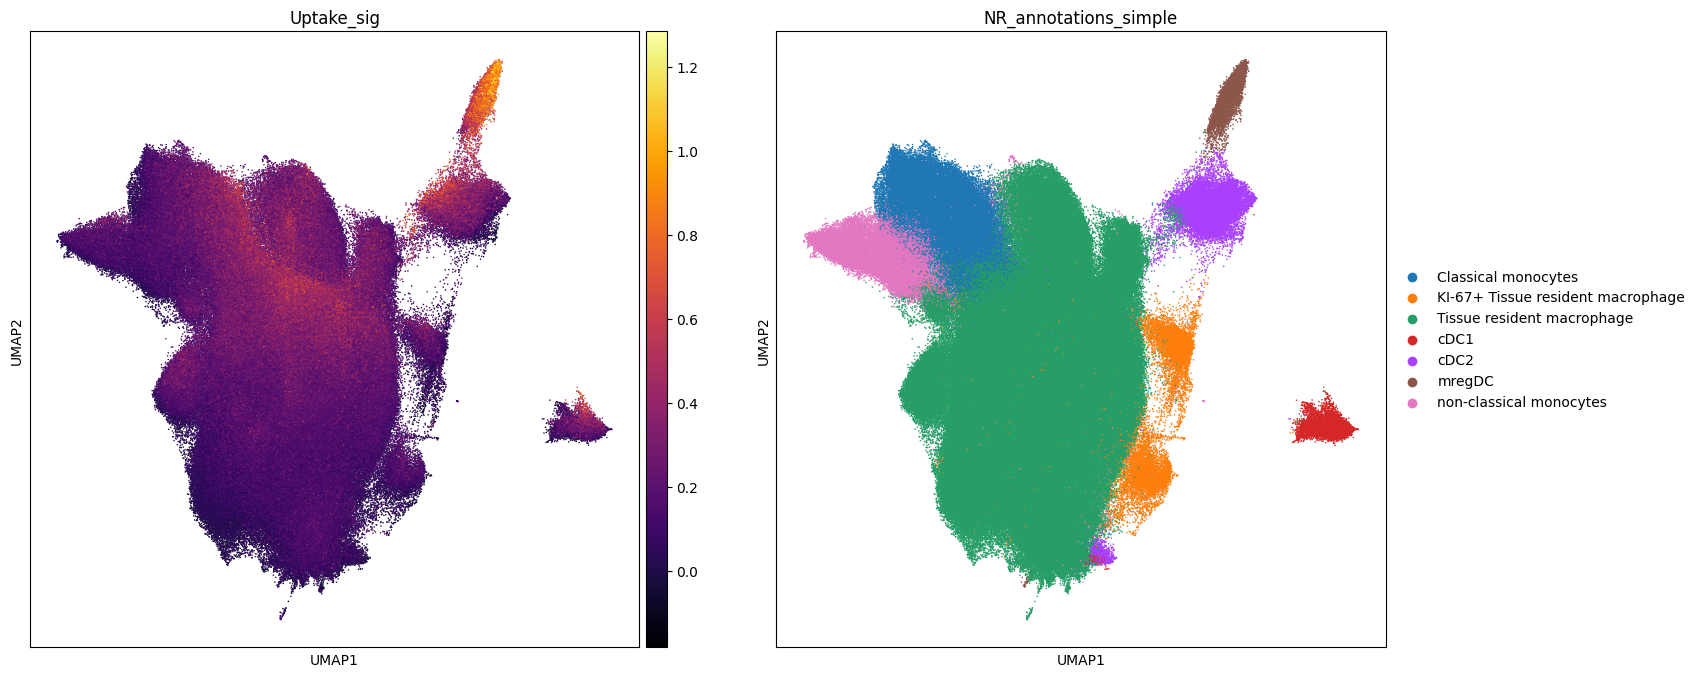

In [ ]:
#plotting 
with plt.rc_context({"figure.figsize": (8, 8)}):
    sc.pl.umap(data, color=colour_vars, ncols=2, size=5, color_map="inferno")

In [ ]:
# Calculate the mean scores for each cluster
cluster_labels = data.obs['NR_annotations_simple']
uptake_scores = data.obs['Uptake_sig']

In [ ]:
# Create a DataFrame with the mean scores per cluster
scores_df = pd.DataFrame({
    'Uptake_score': uptake_scores.groupby(cluster_labels).mean(),
})

/scratch/temp/11603491/ipykernel_2086221/2087912047.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


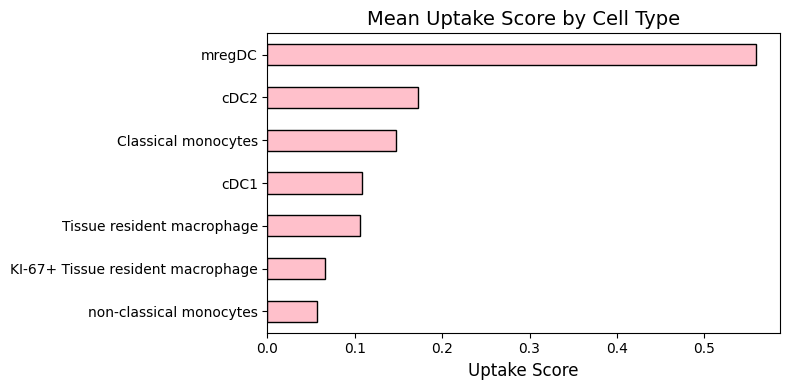

In [ ]:
# Plot as a horizontal bar chart
plt.figure(figsize=(8, 4))
scores_df['Uptake_score'].sort_values().plot.barh(
    color='pink', edgecolor='black', legend=False
)
plt.title("Mean Uptake Score by Cell Type", fontsize=14)
plt.xlabel("Uptake Score", fontsize=12)
plt.ylabel("")
plt.tight_layout()
plt.show()

### From the above two figures we can see that our in vitro signature aligns with mregDC. While there is enrichment for the signature in other areas of the plot, which may represent populations taking up tumour, the signature as a whole appears very distinct and highly enriched by mregDC

### split by cancer subtype, seperated by sample type

In [ ]:
#make sub-objects for primary, mets, and healthy
#make OC object

#make an object for just primary and metastatic tumours
data_primary = data[data.obs["sample_type_major2"] == "primary tumour"]
data_mets = data[data.obs["sample_type_major2"] == "metastatic tumour"]
data_H = data[data.obs["sample_type_major2"] == "healthy"]
data_OC = data[data.obs["cancer_with_H"] == "HGSOC"]

/scratch/temp/11603491/ipykernel_2086221/2265545486.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


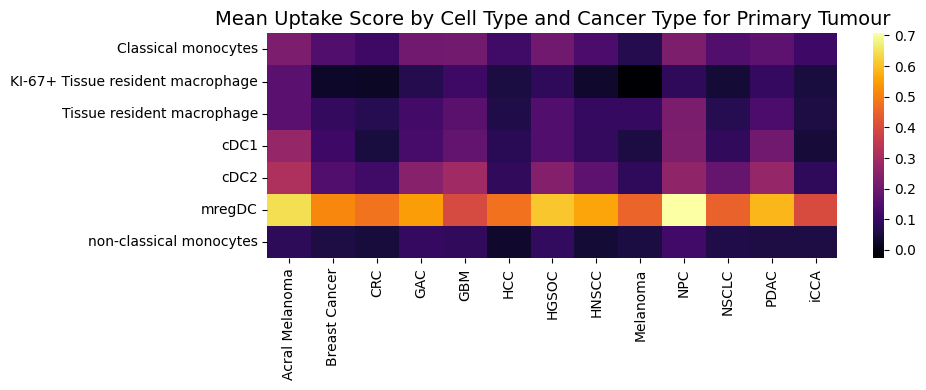

In [ ]:
#Primary:

# Calculate the mean scores for each cancer type
cell_types = data_primary.obs['NR_annotations_simple']
cancer_types = data_primary.obs['cancer_with_H']
uptake_scores = data_primary.obs['Uptake_sig']

# Create a DataFrame with the mean scores per cell type and cancer type
scores_df = pd.DataFrame({
    'Uptake_score': uptake_scores.groupby([cancer_types, cell_types]).mean(),
})

# Pivot the DataFrame to have cancer types as columns and cell types as rows
scores_df = scores_df.unstack(level=1).T  # Unstack cancer types to columns, leaving cell types as rows

# Remove the "Uptake_score" prefix from the row labels
scores_df.index = scores_df.index.droplevel(0)  # Drop the first level of the index (Uptake_score)

# Plot the heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(scores_df, cmap='inferno', annot=False, cbar=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Mean Uptake Score by Cell Type and Cancer Type for Primary Tumour', fontsize=14)
plt.tight_layout()
plt.show()

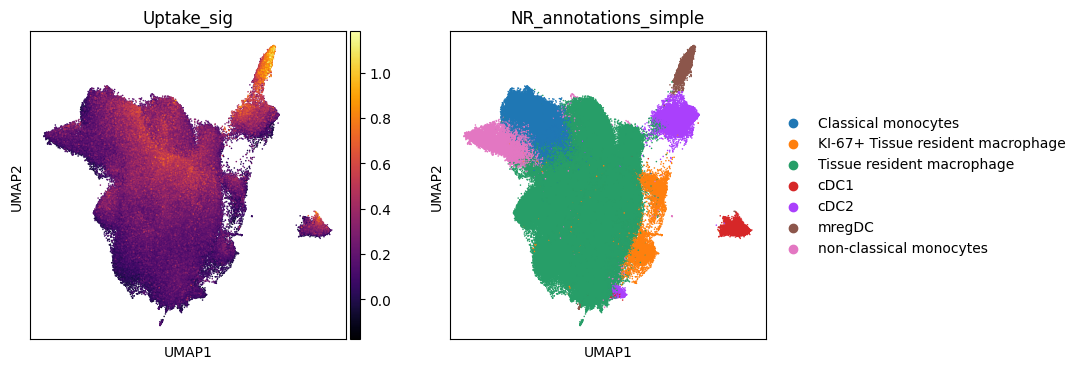

In [ ]:
#plotting 
with plt.rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(data_primary, color=colour_vars, ncols=2, size=5, color_map="inferno")